In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neat.fields import StellnaQS
from neat.tracing import ChargedParticle, ParticleOrbit

In [2]:
# Radial position of particles
s_i=0.75
# Poloidal position of particles
theta_=np.arange(0, 2*np.pi,2*np.pi/100)

# Reactor setup
B0 = 5.3267         # ARIES-CS |B|
R_major = 7.7495*2  # ARIES-CS major radius x2
r_minor = 1.7044    # ARIES-CS minor radius

# List of working stellarators
stellarator = ["precise QA", "2022 QH nfp4 well"]

# QA scaled stellarator
g_field_basis_qa = StellnaQS.from_paper(stellarator[0], B0=B0, nphi=101)
g_field_qa = StellnaQS(
        rc=g_field_basis_qa.rc * R_major,
        zs=g_field_basis_qa.zs * R_major,
        etabar=g_field_basis_qa.etabar / R_major,
        B2c=g_field_basis_qa.B2c * (B0 / R_major / R_major),
        B0=B0,
        nfp=g_field_basis_qa.nfp,
        order="r3",
        nphi=101,
    )

# QH scaled stellarator
g_field_basis_qh = StellnaQS.from_paper(stellarator[1], B0=B0, nphi=101)
g_field_qh = StellnaQS(
        rc=g_field_basis_qh.rc * R_major,
        zs=g_field_basis_qh.zs * R_major,
        etabar=g_field_basis_qh.etabar / R_major,
        B2c=g_field_basis_qh.B2c * (B0 / R_major / R_major),
        B0=B0,
        nfp=g_field_basis_qh.nfp,
        order="r3",
        nphi=101,
    )

etabar_qa=g_field_qa.etabar
etabar_qh=g_field_qh.etabar
print(etabar_qa)
print(etabar_qh)

-0.043770003254755975
0.07100305042407445


In [3]:
step_i=1
nfp_qa=g_field_qa.nfp
nfp_qh=g_field_qh.nfp
s_initials = np.round(np.arange(s_i,0.96,step_i), 2) # psi/psi_a for vmec

# Initial values for lambdas
lambdas=np.round(np.arange(0.8,0.999,0.01), 2) # = mu * B0 / energy

# Initial angular values

theta_initials=np.round(np.arange(0,2*np.pi,2*np.pi/16), 2)         # initial poloidal angle (vartheta=theta_Boozer - N phi_Boozer)
phi_initials_qa=np.round(np.arange(0,2*np.pi/nfp_qa,2*np.pi/nfp_qa/4), 2)    # initial toroidal angle (cylindrical on axis)
phi_initials_qh=np.round(np.arange(0,2*np.pi/nfp_qh,2*np.pi/nfp_qh/4), 2)    # initial toroidal angle (cylindrical on axis)

#Particle values
B0 = 5.3267         # Tesla, magnetic field on-axis (ARIES-CS)
energy = 3.52e6     # electron-volt
charge = 2          # times charge of proton
mass = 4            # times mass of proton
nsamples = 400   # resolution in time
tfinal = 1e-4       # seconds
constant_b20 = False # use a constant B20 (mean value) or the real function

g_orbits_qa = [
    ParticleOrbit(
        ChargedParticle(
            r_initial=r_minor*np.sqrt(s_initial),
            theta_initial=theta_initial-(g_field_qa.iota-g_field_qa.iotaN)*phi_initial,
            phi_initial=phi_initial,
            energy=energy,
            Lambda=lambdas[i],
            charge=charge,
            mass=mass,
            vpp_sign=vpp_sign,
        ),
        g_field_qa,
        nsamples=nsamples,
        tfinal=tfinal,
        constant_b20=constant_b20
    )
    for i in np.arange(lambdas.size)
    for s_initial in s_initials
    for theta_initial in theta_initials
    for phi_initial in phi_initials_qa
    for vpp_sign in [+1,-1]
]

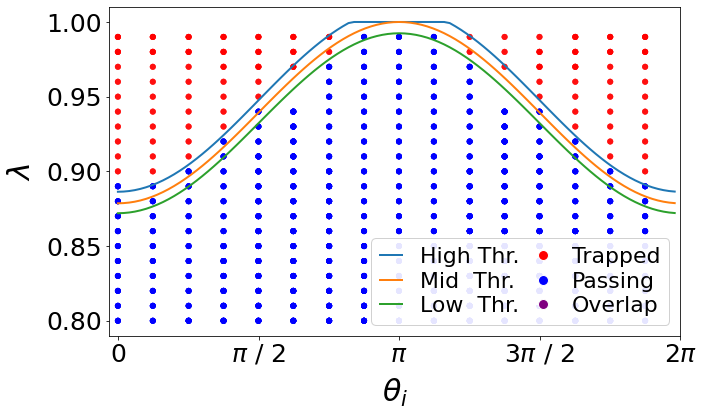

In [4]:
## QA trapped threshold

# Assumed interval for oscillation in QA
delta_s=0.4

# 1st order near axis fields
B_i=(1 + np.sqrt(s_i)*r_minor*etabar_qa*np.cos(theta_))
min_factor=min((1,s_i + delta_s))
B_min = 1 + np.sqrt(min_factor)*r_minor*abs(etabar_qa)
B_mid = 1 + np.sqrt(s_i)*r_minor*abs(etabar_qa)
max_factor=max((0.001,s_i - delta_s))
B_max = 1 + np.sqrt(max_factor)*r_minor*abs(etabar_qa)

# Thresholds for lambda value
Max_bar=B_i/B_max
Mid_bar=B_i/B_mid
Low_bar=B_i/B_min

# Thresholds limited at 1
Max_bar[Max_bar>1]=1
Mid_bar[Mid_bar>1]=1
Low_bar[Low_bar>1]=1

plt.figure(figsize=(10, 6))
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('font', size=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', linewidth=2)	
plt.plot(theta_, Max_bar, label='High bar')
plt.plot(theta_, Mid_bar, label='Medium bar')
plt.plot(theta_, Low_bar, label='Low bar')
stuff=[(
    g_orbits_qa[i].particle.theta_initial,
    g_orbits_qa[i].particle.Lambda,
    int(g_orbits_qa[i].trapped),
    (g_orbits_qa[i].r_pos[-1] > r_minor*np.sqrt(0.99))
 ) for i in range(len(g_orbits_qa))]

stuff=np.einsum('ij->ji',stuff)
# plt.scatter(stuff[0][stuff[2]==0.0],stuff[1][stuff[2]==0.0],color='b', edgecolors='none')
# plt.scatter(stuff[0][stuff[2]==1.0],stuff[1][stuff[2]==1.0],color='r', alpha=0.15, edgecolors='none')

plt.scatter(stuff[0][(stuff[2]==0.0) & (stuff[3]==0.0)],stuff[1][(stuff[2]==0.0) & (stuff[3]==0.0)],label='Not-Lost Passing',color='b', edgecolors='none')
plt.scatter(stuff[0][(stuff[2]==1.0)],stuff[1][(stuff[2]==1.0)],label='Trapped',color='r', alpha=0.5,edgecolors='none')
plt.xlim(-0.1,np.pi*2)
plt.ylim(0.79,1.01)
plt.xticks((0,np.pi/2,np.pi,3*np.pi/2,2*np.pi),('0',r'$\pi \ / \ 2$',r'$\pi$',r'$3 \pi \ / \ 2$',r'$2\pi$'))

from matplotlib.lines import Line2D
# Create a custom legend with specific blend of red and blue for overlapping points
legend_elements = [
    Line2D([0], [0], color='C0', alpha=1, lw=2, label='High Thr.'),
    Line2D([0], [0], color='C1', alpha=1, lw=2, label='Mid  Thr.'),
    Line2D([0], [0], color='C2', alpha=1, lw=2, label='Low  Thr.'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Trapped'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Passing'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=(0.5, 0, 0.5, 1), markersize=10, label='Overlap')
]

plt.tick_params(axis='x', labelsize=25)
plt.xlabel(r'$\theta_i$',fontsize=30,labelpad=10)
plt.tick_params(axis='y', labelsize=25)
plt.ylabel(r'$\lambda$',fontsize=30,labelpad=10)
# plt.legend(loc='lower right')
plt.legend(handles=legend_elements, loc='lower right', framealpha=0.9, fontsize=22, ncols=2, \
            handlelength=1, labelspacing=0.2, columnspacing=0.6)
plt.tight_layout()
plt.savefig(f'QA_Threshold_s_i={s_i}_alt.pdf')
plt.show()

In [5]:
g_orbits_qh = [
    ParticleOrbit(
        ChargedParticle(
            r_initial=r_minor*np.sqrt(s_initial),
            theta_initial=theta_initial,
            phi_initial=phi_initial,
            energy=energy,
            Lambda=lambdas[i],
            charge=charge,
            mass=mass,
            vpp_sign=vpp_sign,
        ),
        g_field_qh,
        nsamples=nsamples,
        tfinal=tfinal,
        constant_b20=constant_b20
    )
    for i in np.arange(lambdas.size)
    for s_initial in s_initials
    for theta_initial in theta_initials
    for phi_initial in phi_initials_qh
    for vpp_sign in [+1,-1]
]

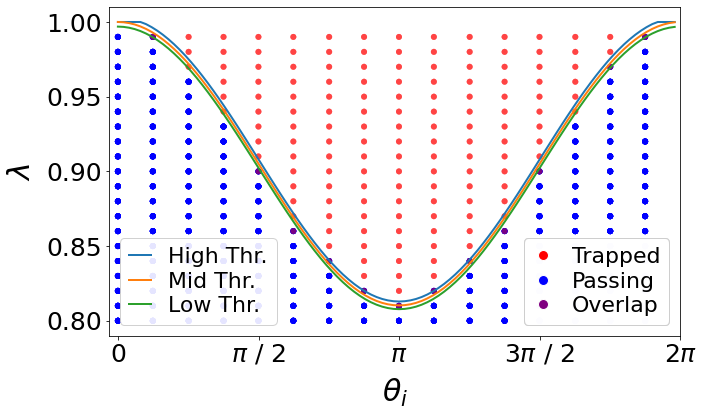

In [6]:
## QH trapped threshold

# Assumed interval for oscillation in QH
delta_s=0.1

# 1st order near axis fields
B_i = 1 + np.sqrt(s_i)*r_minor*etabar_qh*np.cos(theta_) # initial field
min_factor = min((1,s_i + delta_s))
B_min = 1 + np.sqrt(min_factor)*r_minor*abs(etabar_qh) # low threshold field
B_mid = 1 + np.sqrt(s_i)*r_minor*abs(etabar_qh) # mid threshold field
max_factor = max((0.001,s_i - delta_s))
B_max = 1 + np.sqrt(max_factor)*r_minor*abs(etabar_qh) # high threshold field

# Thresholds for lambda value
Max_bar=B_i/B_max
Mid_bar=B_i/B_mid
Low_bar=B_i/B_min

# Thresholds limited at 1
Max_bar[Max_bar>1]=1
Mid_bar[Mid_bar>1]=1
Low_bar[Low_bar>1]=1

# Extracting useful information from orbits
stuff=[(
    g_orbits_qh[i].particle.theta_initial,
    g_orbits_qh[i].particle.Lambda,
    int(g_orbits_qh[i].trapped),
    (g_orbits_qh[i].r_pos[-1] > r_minor*np.sqrt(0.99))
 ) for i in range(len(g_orbits_qh))]

# Inverting order of arrays
stuff=np.einsum('ij->ji',stuff)

# Creating plot
fig, ax = plt.subplots(figsize=(10, 6))
# plt.scatter(stuff[0][stuff[2]==0.0],stuff[1][stuff[2]==0.0],label='Passing',color='b', edgecolors='none')
# plt.scatter(stuff[0][stuff[2]==1.0],stuff[1][stuff[2]==1.0],label='Trapped',color='r',alpha=0.5, edgecolors='none')
plt.scatter(stuff[0][(stuff[2]==0.0) & (stuff[3]==0.0)],stuff[1][(stuff[2]==0.0) & (stuff[3]==0.0)],label='Not-Lost Passing',color='b', edgecolors='none')
plt.scatter(stuff[0][(stuff[2]==1.0)],stuff[1][(stuff[2]==1.0)],label='Trapped',color='r', alpha=0.15,edgecolors='none')
plt.plot(theta_, Max_bar,label='High bar')
plt.plot(theta_, Mid_bar,label='Medium bar')
plt.plot(theta_, Low_bar, label='Low bar')

plt.xlim(-0.1,np.pi*2)
plt.ylim(0.79,1.01)
plt.xticks((0,np.pi/2,np.pi,3*np.pi/2,2*np.pi),('0',r'$\pi \ / \ 2$',r'$\pi$',r'$3 \pi \ / \ 2$',r'$2\pi$'))

# Create a custom legend with specific blend of red and blue for overlapping points
legend_elements = [
    Line2D([0], [0], color='C0', alpha=1, lw=2, label='High Thr.'),
    Line2D([0], [0], color='C1', alpha=1, lw=2, label='Mid Thr.'),
    Line2D([0], [0], color='C2', alpha=1, lw=2, label='Low Thr.')]
legend_elements2 = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Trapped'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Passing'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=(0.5, 0, 0.5, 1), markersize=10, label='Overlap')
]

plt.tick_params(axis='x', labelsize=25)
plt.xlabel(r'$\theta_i$',fontsize=30,labelpad=10)
plt.tick_params(axis='y', labelsize=25)
plt.ylabel(r'$\lambda$',fontsize=30,labelpad=10)

# Creating two different legend boxes
legend1=ax.legend(handles=legend_elements, loc='lower left', framealpha=0.9, fontsize=22, ncols=1, \
            handlelength=1, labelspacing=0.2)
ax.add_artist(legend1)
legend2=ax.legend(handles=legend_elements2, loc='lower right', framealpha=0.9, fontsize=22, ncols=1, \
            handlelength=1, labelspacing=0.2)
ax.add_artist(legend2)

plt.tight_layout()
plt.savefig(f'QH_Threshold_s_i={s_i}_alt.pdf')
plt.show()